In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words as dictionary
nltk.download('stopwords')
nltk.download('words')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from joblib import dump, load

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
POS_PATH = 'data/pos_clean.txt'
NEG_PATH = 'data/neg_clean.txt'

with open(POS_PATH, 'r') as file:
    pos = file.readlines()

with open(NEG_PATH, 'r') as file:
    neg = file.readlines()

df_pos = pd.DataFrame({'text': pos})
df_neg = pd.DataFrame({'text': neg})

df_pos['label'] = 1
df_neg['label'] = 0

df = pd.concat([df_pos, df_neg], ignore_index=True)
df

,text,label
0,Luckyland Slots Play 100 Slots Games Online Fo...,1
1,Vegas Wild Casino 300 50 Free Spins Welcome Bo...,1
2,Toggle navigationSPORTSBOOKLIVE BETTINGCASINOH...,1
3,HighRoller.com Roll With Us!Join NowLog inCasi...,1
4,"Live Sports Betting, Live Streaming, Casino Yo...",1
...,...,...
1268,Public Discord Servers and Bots Discord Me Gro...,0
1269,Google Photos Get Google Photos Go to Google P...,0
1270,Metro.co.uk: News Sport Showbiz Celebrities fr...,0
1271,Home Microsoft 365 Office Products Microsoft 3...,0


In [3]:
print("len", len(df))
df['text'] = df['text'].apply(lambda x: x.lower())
df.loc[:, 'word_count'] = df['text'].str.split().str.len()
df = df[df['word_count'] >= 30]
df = df.drop(columns=['word_count'])
print("len", len(df))
df

len 1273
len 1273


,text,label
0,luckyland slots play 100 slots games online fo...,1
1,vegas wild casino 300 50 free spins welcome bo...,1
2,toggle navigationsportsbooklive bettingcasinoh...,1
3,highroller.com roll with us!join nowlog incasi...,1
4,"live sports betting, live streaming, casino yo...",1
...,...,...
1268,public discord servers and bots discord me gro...,0
1269,google photos get google photos go to google p...,0
1270,metro.co.uk: news sport showbiz celebrities fr...,0
1271,home microsoft 365 office products microsoft 3...,0


In [4]:
print("num datapoints", len(df))
print("num positive datapoints", len(df[df['label'] == 1]))
print("num negative datapoints", len(df[df['label'] == 0]))

num_positive = len(df[df['label'] == 1])
num_negative = len(df[df['label'] == 0])

min_samples = min(num_positive, num_negative)

# Undersample
df_positive = df[df['label'] == 1].sample(n=min_samples, random_state=42)
df_negative = df[df['label'] == 0].sample(n=min_samples, random_state=42)

# Concatenate the undersampled dataframes
df_balanced = pd.concat([df_positive, df_negative], ignore_index=True)

print("-----------------------------------------------------------")
print("num datapoints", len(df_balanced))
print("num positive datapoints", len(df_balanced[df_balanced['label'] == 1]))
print("num negative datapoints", len(df_balanced[df_balanced['label'] == 0]))

df_balanced

num datapoints 1273
num positive datapoints 751
num negative datapoints 522
-----------------------------------------------------------
num datapoints 1044
num positive datapoints 522
num negative datapoints 522


,text,label
0,is ninja casino a scam?skip to contentmenuis c...,1
1,parimatch casino best offers pokies onlinecasi...,1
2,казино игри ᐉ онлайн казино безплатни хазартни...,1
3,lottohelden.de: online lotto spielen beim test...,1
4,access restricted access restricted voodoodrea...,1
...,...,...
1039,stream live video online vimeo livestreamlives...,0
1040,adobe help center adobe help center hi what ca...,0
1041,website builder - create a free website today ...,0
1042,le figaro - actualité en direct et information...,0


In [5]:
X = df["text"]
y = df["label"]
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.3, random_state=42)

train_df = pd.concat([pd.DataFrame(X_train_df, columns=["text"]), pd.DataFrame(y_train_df, columns=["label"])], axis=1)
test_df = pd.concat([pd.DataFrame(X_test_df, columns=["text"]), pd.DataFrame(y_test_df, columns=["label"])], axis=1)

train_df, test_df

(                                                   text  label
 567   new bingo site katies bingo spend 10 get 40 to...      1
 545   tipsport největší komunita sázkařů kurzové sáz...      1
 644   live sports betting odds, online sportsbook, c...      1
 909   philips - united kingdom important information...      0
 802   tensorflow install learn introduction new to t...      0
 ...                                                 ...    ...
 1044  bevor sie zu google maps weitergehenanmeldenan...      0
 1095  ouest-france : toute l'actualité en direct l'i...      0
 1130  pocket: home pocket sign up how to save go pre...      0
 860   forbessubscribe to newsletterssign inbreaking2...      0
 1126  enterprise advertising analytics solutions - g...      0
 
 [891 rows x 2 columns],
                                                    text  label
 43    joo casino: online slots, table games, live ga...      1
 1160  home u.s. department of labor skip to main con...      0
 128   sports

In [6]:
stop_words = stopwords.words('english') + stopwords.words('german')

def remove_stopwords_and_split(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

words_series = train_df['text'].apply(remove_stopwords_and_split)
all_words = [word for words_list in words_series for word in words_list]

word_freq_df = pd.DataFrame({'word': all_words})
word_freq = word_freq_df['word'].value_counts().reset_index()
word_freq.columns = ['word', 'freq']

word_freq

,word,freq
0,online,6709
1,-,6547
2,casino,4916
3,slot,3789
4,de,3764
...,...,...
184231,-such,1
184232,greater.cash,1
184233,rush-,1
184234,racingacca,1


In [7]:
# Remove non-valid words
print("num words before:", len(word_freq))
new_word_freq = word_freq[word_freq['word'].isin(dictionary.words())]
print("num words after:", len(new_word_freq))

num words before: 184236
num words after: 12168


In [8]:
# Remove words with frequency less than 10
print("num words before:", len(new_word_freq))
new_word_freq = new_word_freq[new_word_freq['freq'] >= 10]
print("num words after:", len(new_word_freq))

num words before: 12168
num words after: 3690


In [9]:
bag_of_words = new_word_freq['word'].tolist()

with open('bag_of_words.txt', 'w') as file:
    for word in bag_of_words:
        file.write(word + '\n')

In [10]:
def create_features(df):
    df['features'] = None
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        text = row['text']
        website_words = text.split()
        website_words = list(dict.fromkeys(website_words))
        features_local = [1 if w in website_words else 0 for w in bag_of_words]
        df.at[idx, 'features'] = features_local
    return df
train_df = create_features(train_df)
test_df = create_features(test_df)
train_df

Processing rows: 100%|██████████| 382/382 [00:12<00:00, 29.99it/s]


,text,label,features
567,new bingo site katies bingo spend 10 get 40 to...,1,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
545,tipsport největší komunita sázkařů kurzové sáz...,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
644,"live sports betting odds, online sportsbook, c...",1,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."
909,philips - united kingdom important information...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
802,tensorflow install learn introduction new to t...,0,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...
1044,bevor sie zu google maps weitergehenanmeldenan...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1095,ouest-france : toute l'actualité en direct l'i...,0,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1130,pocket: home pocket sign up how to save go pre...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
860,forbessubscribe to newsletterssign inbreaking2...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_train = np.array(train_df['features'].tolist())
y_train = np.array(train_df['label'].tolist())

X_test = np.array(test_df['features'].tolist())
y_test = np.array(test_df['label'].tolist())


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# C = 1.0
# model = SVC(kernel='linear', C=C, probability=True).fit(X_train, y_train)

model = LogisticRegression()
model.fit(X_train, y_train)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.07%


In [12]:
# save model weights
dump(model, 'weights_logistic_regression.joblib')

['weights_new.joblib']

In [13]:
# for plot later
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test)

y_pred_linear = model.predict(X_test)

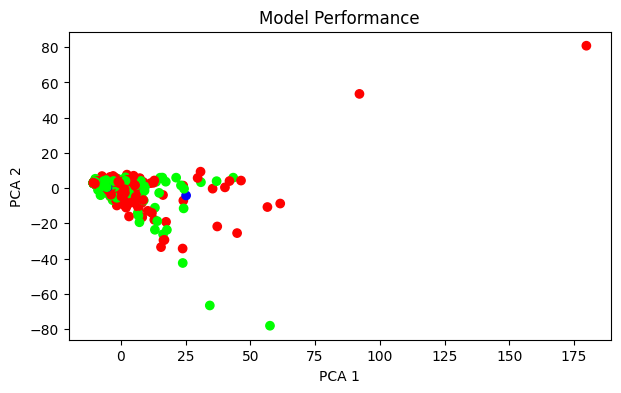

In [14]:
def repaint_scatter(y):
    for idx in range(len(y)):
        if y[idx] == 1: # incorrect
            y[idx] = -1
        else: # correct
            if y_train[idx] == 1: # casino
                y[idx] = 0
            else: # not casino
                y[idx] = 1
    return y
    
# Titles for the plots
title = 'Model Performance'

# Set the figure size
plt.figure(figsize=(7, 4))

# Scatter plot of the reduced data
y = repaint_scatter(np.abs(y_test - y_pred_linear))

# green: correctly classified and normal website
# red: correctly classified and casino website
# blue: incorrectly classified
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.brg)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(title)

plt.show()

### Predict

In [36]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive'
}

url = "https://www.slotstemple.com/"

response = requests.get(url, headers=headers)
txt = ""
if response.ok:
    soup = BeautifulSoup(response.content, 'html.parser')
    txt = soup.get_text().replace("\n", " ")
txt

''

In [ ]:
txt_clean = txt.lower()
txt_clean = txt_clean.split()
txt_clean = list(set(txt_clean))
txt_clean = ' '.join(txt_clean)

df_predict = pd.DataFrame([txt_clean], columns=['text'])

bag_of_words = []
with open('bag_of_words.txt', 'r') as file:
    bag_of_words = file.readlines()
bag_of_words = [word.strip() for word in bag_of_words]
df_predict = create_features(df_predict)

feature_vec = np.array(df_predict['features'].tolist())

In [38]:
svm = load('weights_logistic_regression.joblib')

label = svm.predict(feature_vec)
prob = svm.predict_proba(feature_vec)
label[0], prob[0]

(1, array([0.02129239, 0.97870761]))